# Homework 02: Multi-Class Classification with Neural Networks

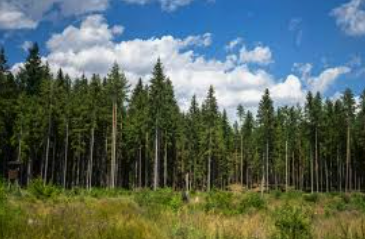

In this assignment, you’ll extend your Keras classification toolkit by training a neural network on a **balanced subset of the Forest Cover (Covertype) dataset**. We’ll begin with a simple baseline network, then study how performance changes as we vary **batch size**, **learning rate**, and apply a **cosine-decay schedule**.

For each configuration, you will consider a range of hyperparameter values, plot training/validation **loss** and **accuracy** over epochs, and determine which choice gave the best performance. 

Finally, you will consider all that you have learned and build your best model and run it on the test set. 


There are 9 graded questions, each worth 9 points, and you get 4 points for free if you complete the whole homework. 


In [31]:
# Useful imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_covtype

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

random_seed = 42

tf.random.set_seed(random_seed)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

In [ ]:
import sys
!{sys.executable} -m pip install -U pillow
!{sys.executable} -m pip install -U scikit-learn
!{sys.executable} -m pip install -U requests


Looking in indexes: https://repo.forge.lmig.com/api/pypi/python/simple


$$k\cdot\sigma$$

In [ ]:
# Utility function: Plotting Training Loss (categorical x-entropy) and Accuracy

# Takes the history object returned by fit

def plot_history(history):
    n_epochs = len(history.history['accuracy'])
    epochs = range(1, n_epochs + 1)

    plt.figure(figsize=(7, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss (Xent)', color='tab:red')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='tab:blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05)
    plt.title('Training Accuracy')
    plt.grid(True)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    final_loss = history.history['loss'][-1]
    final_acc = history.history['accuracy'][-1]
    print(f'Final Training Loss:     {final_loss:.4f}')
    print(f'Final Training Accuracy: {final_acc:.4f}')

## Load the dataset

The dataset is described in detail in the Appendix. For the purposes of this homework, we are selecting a random sample with 2747 samples in each class (to preserve balance), because the original dataset is both very large and very imbalanced, with the smallest class having 2747 samples. 

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import numpy as np

# Load
X, y = fetch_covtype(return_X_y=True)   # y in {1..7}
classes, counts = np.unique(y, return_counts=True)
min_count = counts.min()                # size of rarest class (~2.7k)

# Build perfectly balanced subset (no replacement, no duplicates)
rng = np.random.default_rng(42)
idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = X[idx_bal]
y_sub = y[idx_bal] - 1                  # relabel to 0..6 for Keras
print("Subset shape:", X_sub.shape, "Class counts:", Counter(y_sub))


Subset shape: (19229, 54) Class counts: Counter({np.int32(3): 2747, np.int32(2): 2747, np.int32(6): 2747, np.int32(5): 2747, np.int32(4): 2747, np.int32(1): 2747, np.int32(0): 2747})


## Problem One: Prepare the dataset and build a baseline model

### Part A: Stratified train/test split and standardization

As in Homework 1, follow these steps:

1. **Stratified split:**
   Use `train_test_split` with `stratify=y_sub` to preserve class proportions in both training and test sets. Be sure to set `random_state=random_seed` and `test_size=0.2`.

2. **Standardize features:**
   Scale the input features so they have mean 0 and variance 1.



In [ ]:
# Your code here
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X_sub, y_sub,
    test_size=0.2,
    random_state=random_seed,
    stratify=y_sub
)

# (Optional) sanity check stratification
print("Full:", Counter(y_sub))
print("Train:", Counter(y_train))
print("Test:", Counter(y_test))

# Standardize AFTER split (avoid leakage)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)   # fit on train only
X_test_std  = scaler.transform(X_test)        # transform test using train stats


Full: Counter({np.int32(3): 2747, np.int32(2): 2747, np.int32(6): 2747, np.int32(5): 2747, np.int32(4): 2747, np.int32(1): 2747, np.int32(0): 2747})
Train: Counter({np.int32(5): 2198, np.int32(1): 2198, np.int32(0): 2198, np.int32(2): 2198, np.int32(6): 2197, np.int32(3): 2197, np.int32(4): 2197})
Test: Counter({np.int32(3): 550, np.int32(4): 550, np.int32(6): 550, np.int32(1): 549, np.int32(0): 549, np.int32(5): 549, np.int32(2): 549})


### Part B: Build, compile, train, and evaluate the network

1. **Build the model**

   * Use 2 hidden layers:  input &rarr; 64 &rarr; 32 &rarr; output.
   * Apply the `relu` activation for the hidden layers and `softmax` for the output layer.

2. **Compile the model**

    * Use the following parameters


           optimizer = Adam(learning_rate=0.0001),  
           loss = 'sparse_categorical_crossentropy',  
           metrics = ['accuracy']


4. **Train the model**

   * Run for **20 epochs**.
   * Use a `batch_size` of 32.

5. **Evaluate training**

   * Plot the training loss and accuracy curves using `plot_history`.

6. **Answer the graded questions**



2026-02-06 14:19:00.778247: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2749 - loss: 1.8147 - val_accuracy: 0.4680 - val_loss: 1.5192
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5282 - loss: 1.2917 - val_accuracy: 0.5811 - val_loss: 1.1155
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5962 - loss: 1.0266 - val_accuracy: 0.6199 - val_loss: 0.9552
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6252 - loss: 0.9220 - val_accuracy: 0.6474 - val_loss: 0.8790
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6489 - loss: 0.8672 - val_accuracy: 0.6726 - val_loss: 0.8345
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6608 - loss: 0.8323 - val_accuracy: 0.6825 - val_loss: 0.8047
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6692 - loss: 0.8068 - val_accuracy: 0.6895 - val_loss: 0.7818
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6787 - loss: 0.7864 - val_accuracy: 0.

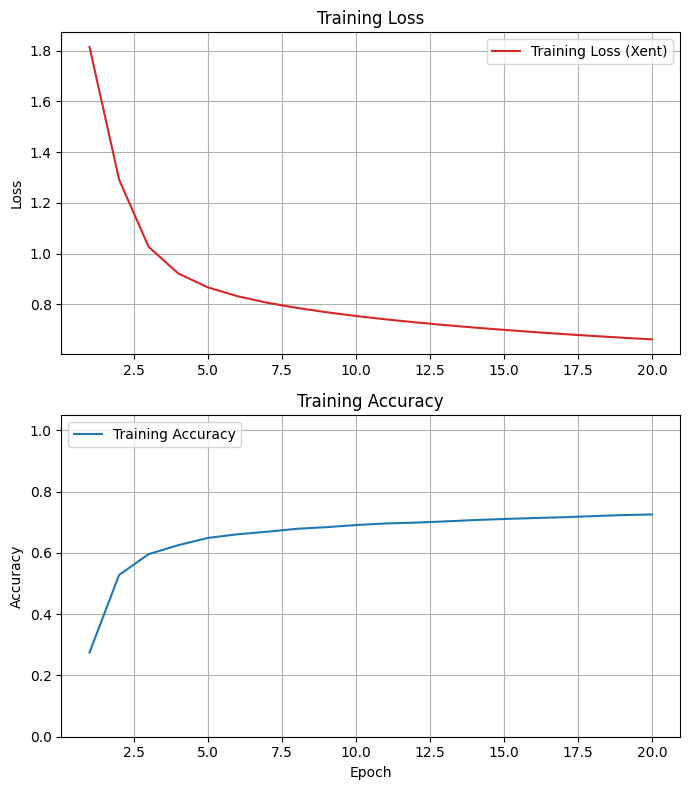

Final Training Loss:     0.6623
Final Training Accuracy: 0.7255
Test loss: 0.6484
Test accuracy: 0.7374


In [ ]:
# Your code here
# Part B: Build, compile, train, evaluate (64 -> 32) with ReLU + Softmax

# --- infer #classes for softmax output ---
n_classes = int(np.max(y_train)) + 1  # works if labels are 0..K-1
# If your labels are not 0..K-1, use: n_classes = len(np.unique(y_train))

model = Sequential([
    Input(shape=(X_train_std.shape[1],)),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(n_classes, activation="softmax")
])

model.summary()

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    X_train_std, y_train,
    validation_data=(X_test_std, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

plot_history(history)

# Evaluate on test set (use these variables for graded questions if needed)
test_loss, test_acc = model.evaluate(X_test_std, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")


In [ ]:
# Set a1a to the final training accuracy at epoch 20
a1a = history.history["accuracy"][-1]


In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a:.4f}')  

a1a = 0.7255


## Problem Two: Batch Sizes

Next, we’ll explore how the **batch size** affects training. .

* Start with the code from Problem One.
* Run **four experiments** using a batch size of 4, 8, 16, and 128, and  displaying the results using `plot_history`.

* Answer the graded questions.

**Note:** Consider using a `for` loop!


Training with batch_size=4
Epoch 1/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5096 - loss: 1.3153 - val_accuracy: 0.6186 - val_loss: 0.9886
Epoch 2/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6421 - loss: 0.8918 - val_accuracy: 0.6763 - val_loss: 0.8293
Epoch 3/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6778 - loss: 0.8004 - val_accuracy: 0.6927 - val_loss: 0.7585
Epoch 4/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6924 - loss: 0.7522 - val_accuracy: 0.7114 - val_loss: 0.7170
Epoch 5/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7040 - loss: 0.7195 - val_accuracy: 0.7184 - val_loss: 0.6887
Epoch 6/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7131 - loss: 0.6945 - val_accuracy: 0.7262 - val_loss: 0.6671
Epoch 7/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7217 - loss: 0.6741 - val_accuracy: 0.7314 - val_loss: 0.6496
Epoch 8/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accura

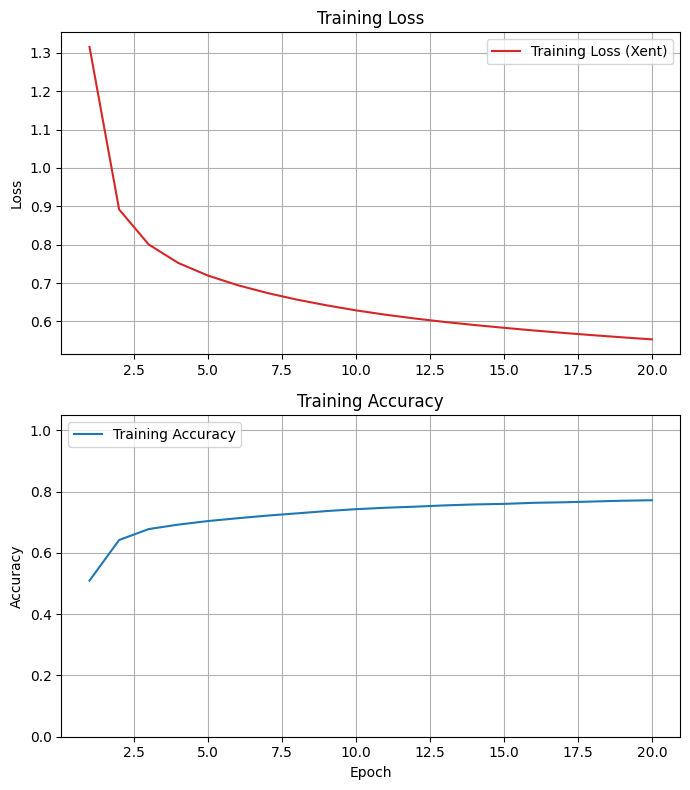

Final Training Loss:     0.5531
Final Training Accuracy: 0.7720
Test loss (bs=4): 0.5503
Test acc  (bs=4): 0.7735

Training with batch_size=8
Epoch 1/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4635 - loss: 1.4937 - val_accuracy: 0.5998 - val_loss: 1.1231
Epoch 2/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6220 - loss: 0.9820 - val_accuracy: 0.6505 - val_loss: 0.9000
Epoch 3/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6536 - loss: 0.8601 - val_accuracy: 0.6799 - val_loss: 0.8167
Epoch 4/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6724 - loss: 0.8042 - val_accuracy: 0.6981 - val_loss: 0.7691
Epoch 5/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6847 - loss: 0.7680 - val_accuracy: 0.7093 - val_loss: 0.7371
Epoch 6/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6971 - loss: 0.7405 - val_accuracy: 0.7155 - val_loss: 0.7126
Epoch 7/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7075 - los

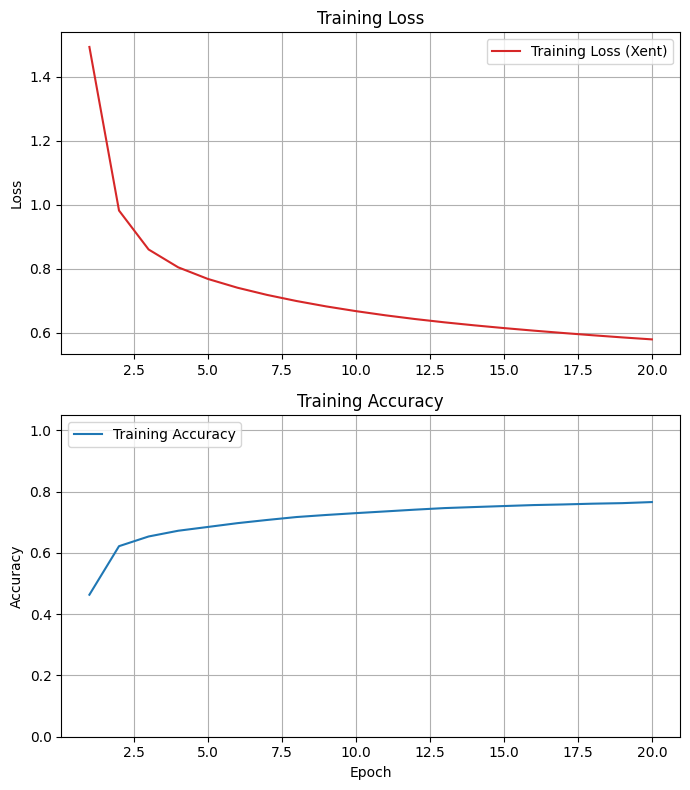

Final Training Loss:     0.5788
Final Training Accuracy: 0.7660
Test loss (bs=8): 0.5735
Test acc  (bs=8): 0.7725

Training with batch_size=16
Epoch 1/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3943 - loss: 1.6765 - val_accuracy: 0.5575 - val_loss: 1.3181
Epoch 2/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5885 - loss: 1.1181 - val_accuracy: 0.6274 - val_loss: 0.9916
Epoch 3/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6300 - loss: 0.9340 - val_accuracy: 0.6583 - val_loss: 0.8779
Epoch 4/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6554 - loss: 0.8613 - val_accuracy: 0.6789 - val_loss: 0.8229
Epoch 5/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6688 - loss: 0.8206 - val_accuracy: 0.6906 - val_loss: 0.7889
Epoch 6/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6785 - loss: 0.7921 - val_accuracy: 0.7007 - val_loss: 0.7632
Epoch 7/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6853 - loss: 0.7694 - v

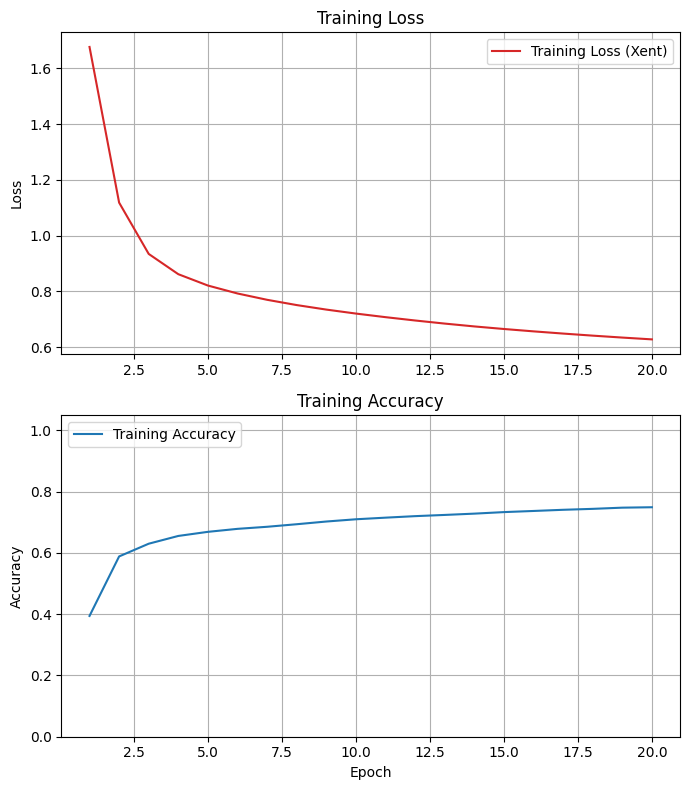

Final Training Loss:     0.6274
Final Training Accuracy: 0.7491
Test loss (bs=16): 0.6147
Test acc  (bs=16): 0.7509

Training with batch_size=128
Epoch 1/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2156 - loss: 1.9629 - val_accuracy: 0.2988 - val_loss: 1.7978
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3809 - loss: 1.6831 - val_accuracy: 0.4379 - val_loss: 1.5694
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4752 - loss: 1.4794 - val_accuracy: 0.5257 - val_loss: 1.3903
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5394 - loss: 1.3190 - val_accuracy: 0.5551 - val_loss: 1.2492
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5642 - loss: 1.1961 - val_accuracy: 0.5658 - val_loss: 1.1433
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5747 - loss: 1.1066 - val_accuracy: 0.5783 - val_loss: 1.0681
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5838 - loss: 1.0433 

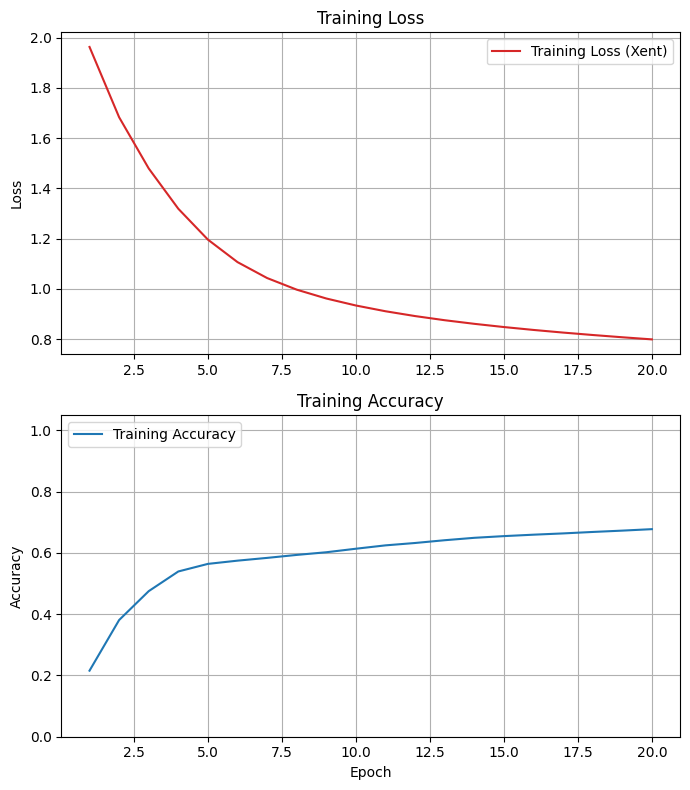

Final Training Loss:     0.7992
Final Training Accuracy: 0.6776
Test loss (bs=128): 0.7820
Test acc  (bs=128): 0.6898


In [ ]:
# Your code here
# Problem Two: Batch size experiments (4, 8, 16, 128)

batch_sizes = [4, 8, 16, 128]
histories = {}          # store History objects by batch size
test_results = {}       # store (loss, acc) by batch size

n_classes = int(np.max(y_train)) + 1  # adjust if labels not 0..K-1

for bs in batch_sizes:
    print("\n" + "="*60)
    print(f"Training with batch_size={bs}")
    
    # Rebuild a fresh model each time (important!)
    model_bs = Sequential([
        Input(shape=(X_train_std.shape[1],)),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(n_classes, activation="softmax")
    ])

    model_bs.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    history_bs = model_bs.fit(
        X_train_std, y_train,
        validation_data=(X_test_std, y_test),
        epochs=20,
        batch_size=bs,
        verbose=1
    )

    print(f"Curves for batch_size={bs}")
    plot_history(history_bs)

    loss_bs, acc_bs = model_bs.evaluate(X_test_std, y_test, verbose=0)
    print(f"Test loss (bs={bs}): {loss_bs:.4f}")
    print(f"Test acc  (bs={bs}): {acc_bs:.4f}")

    histories[bs] = history_bs
    test_results[bs] = (loss_bs, acc_bs)


In [ ]:
# Set a2a to the batch size which produced the best accuracy score at epoch 20

a2a = max(histories, key=lambda bs: histories[bs].history["accuracy"][-1])


In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a}') 

a2a = 4


In [ ]:
# Set a2b to the best accuracy score found

# Best training accuracy at epoch 20 from Problem Two (batch size experiments)
a2b = max(h.history["accuracy"][-1] for h in histories.values())



In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7720


## Problem Three: Learning Rates

Next, we’ll explore how the **learning rate** affects training when using the Adam optimizer.

* Start with the code from **Problem One**.
* Add the `learning_rate` parameter to `Adam`.
* Run **five experiments** using the following values:

        [1e-3, 5e-4, 1e-4,5e-5, 1e-5]

* Display your results using `plot_history` and answer the graded questions.



Training with learning_rate=0.001
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5890 - loss: 1.0345 - val_accuracy: 0.6908 - val_loss: 0.7512
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6957 - loss: 0.7347 - val_accuracy: 0.7267 - val_loss: 0.6700
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7218 - loss: 0.6709 - val_accuracy: 0.7395 - val_loss: 0.6241
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7383 - loss: 0.6308 - val_accuracy: 0.7499 - val_loss: 0.5967
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7487 - loss: 0.6017 - val_accuracy: 0.7621 - val_loss: 0.5745
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7604 - loss: 0.5787 - val_accuracy: 0.7676 - val_loss: 0.5590
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7668 - loss: 0.5599 - val_accuracy: 0.7754 - val_loss: 0.5475
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.774

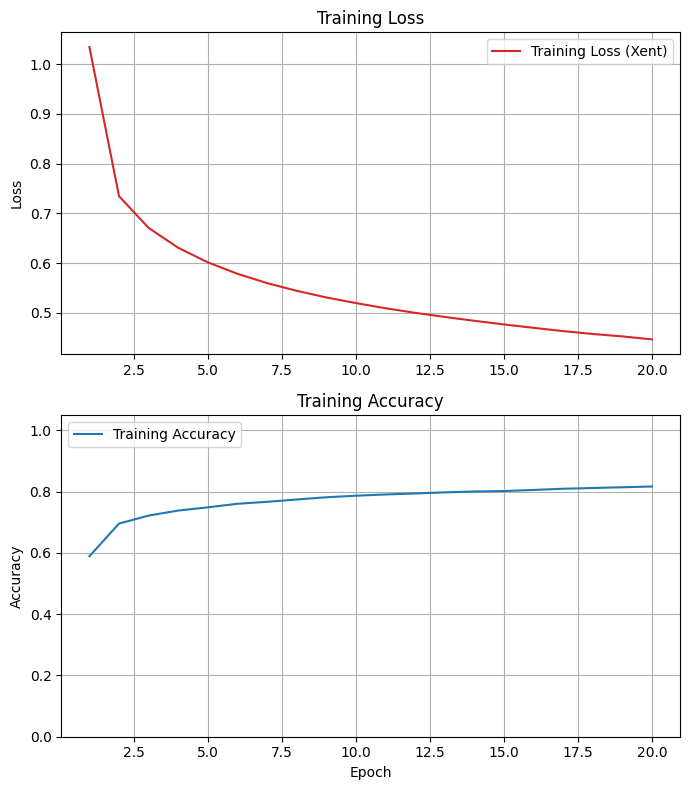

Final Training Loss:     0.4468
Final Training Accuracy: 0.8168
Test loss (lr=0.001): 0.4802
Test acc  (lr=0.001): 0.8071

Training with learning_rate=0.0005
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5432 - loss: 1.2081 - val_accuracy: 0.6500 - val_loss: 0.8605
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6678 - loss: 0.8177 - val_accuracy: 0.7051 - val_loss: 0.7504
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6971 - loss: 0.7422 - val_accuracy: 0.7181 - val_loss: 0.6976
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7159 - loss: 0.6972 - val_accuracy: 0.7314 - val_loss: 0.6620
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7242 - loss: 0.6643 - val_accuracy: 0.7382 - val_loss: 0.6347
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7342 - loss: 0.6388 - val_accuracy: 0.7465 - val_loss: 0.6141
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7422 - l

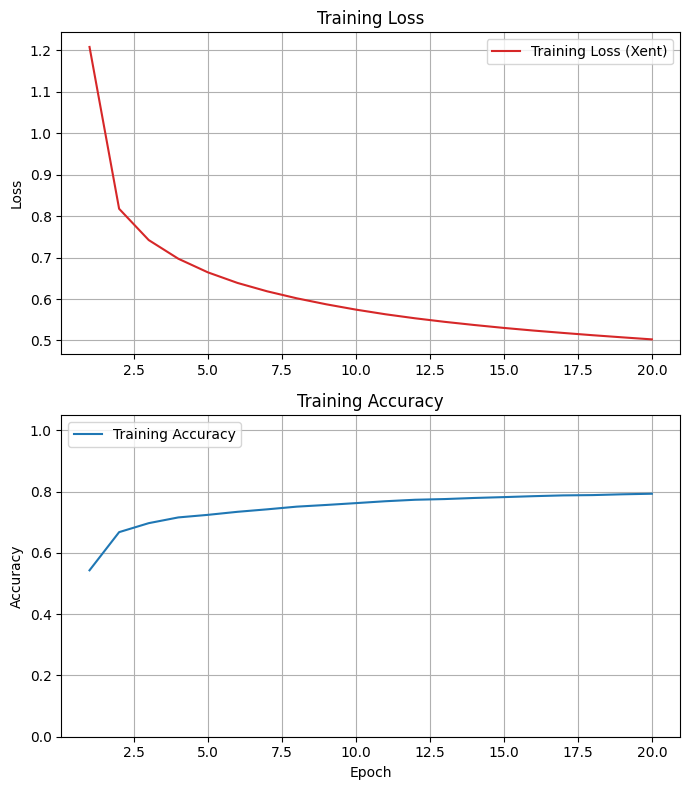

Final Training Loss:     0.5026
Final Training Accuracy: 0.7931
Test loss (lr=0.0005): 0.5092
Test acc  (lr=0.0005): 0.7962

Training with learning_rate=0.0001
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3283 - loss: 1.7130 - val_accuracy: 0.4891 - val_loss: 1.4058
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5479 - loss: 1.2343 - val_accuracy: 0.5988 - val_loss: 1.0861
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6022 - loss: 1.0197 - val_accuracy: 0.6318 - val_loss: 0.9439
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6257 - loss: 0.9219 - val_accuracy: 0.6547 - val_loss: 0.8732
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6450 - loss: 0.8690 - val_accuracy: 0.6690 - val_loss: 0.8306
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6605 - loss: 0.8346 - val_accuracy: 0.6789 - val_loss: 0.8010
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6730 -

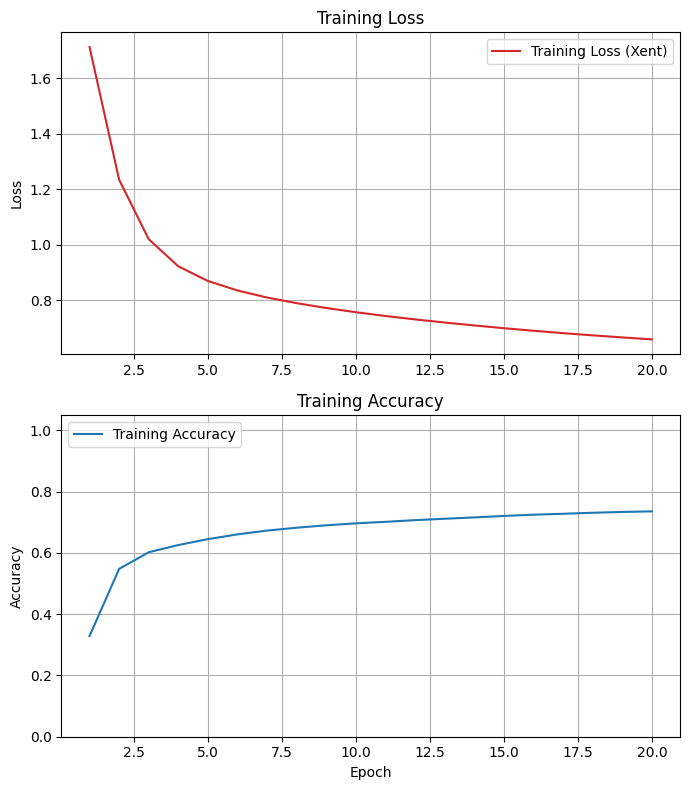

Final Training Loss:     0.6583
Final Training Accuracy: 0.7356
Test loss (lr=0.0001): 0.6391
Test acc  (lr=0.0001): 0.7382

Training with learning_rate=5e-05
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2390 - loss: 1.9610 - val_accuracy: 0.3469 - val_loss: 1.7900
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4283 - loss: 1.6420 - val_accuracy: 0.4873 - val_loss: 1.5092
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5191 - loss: 1.3917 - val_accuracy: 0.5530 - val_loss: 1.2864
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5661 - loss: 1.2017 - val_accuracy: 0.5819 - val_loss: 1.1264
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5937 - loss: 1.0727 - val_accuracy: 0.6066 - val_loss: 1.0220
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6171 - loss: 0.9905 - val_accuracy: 0.6261 - val_loss: 0.9546
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6318 - 

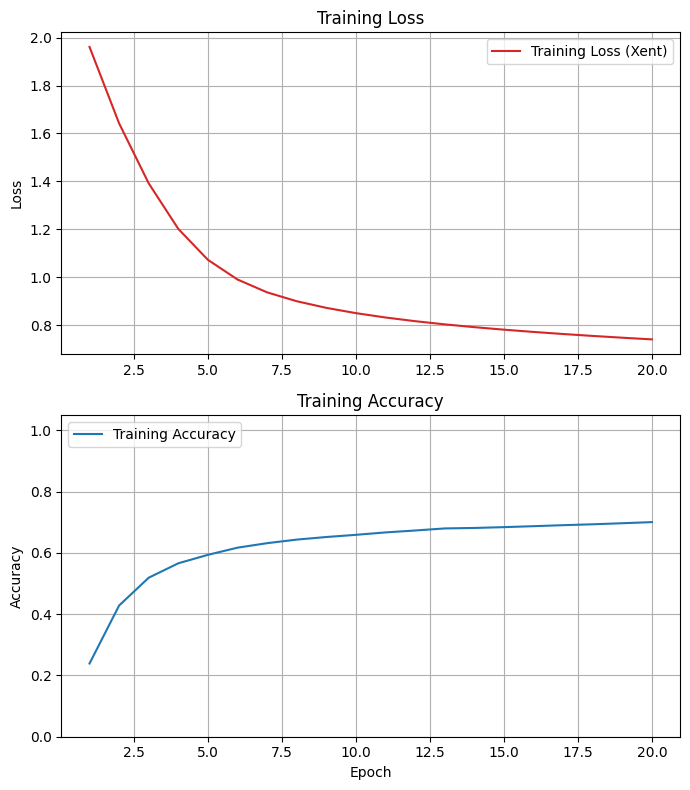

Final Training Loss:     0.7407
Final Training Accuracy: 0.7005
Test loss (lr=5e-05): 0.7231
Test acc  (lr=5e-05): 0.7106

Training with learning_rate=1e-05
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1814 - loss: 1.9756 - val_accuracy: 0.2174 - val_loss: 1.9206
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2377 - loss: 1.9015 - val_accuracy: 0.2800 - val_loss: 1.8521
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3056 - loss: 1.8371 - val_accuracy: 0.3393 - val_loss: 1.7913
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3451 - loss: 1.7788 - val_accuracy: 0.3752 - val_loss: 1.7355
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3779 - loss: 1.7241 - val_accuracy: 0.4072 - val_loss: 1.6826
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4119 - loss: 1.6717 - val_accuracy: 0.4366 - val_loss: 1.6315
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4391 - lo

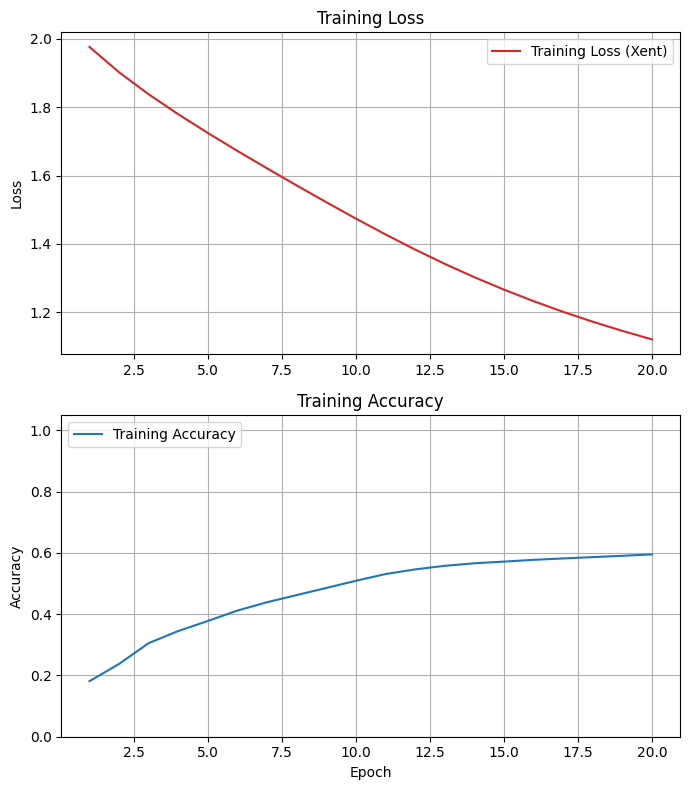

Final Training Loss:     1.1212
Final Training Accuracy: 0.5951
Test loss (lr=1e-05): 1.0987
Test acc  (lr=1e-05): 0.6069


In [ ]:
# Your code here
# Problem Three: Learning rate experiments for Adam

learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
lr_histories = {}
lr_test_results = {}

n_classes = int(np.max(y_train)) + 1  # adjust if labels not 0..K-1

for lr in learning_rates:
    print("\n" + "="*60)
    print(f"Training with learning_rate={lr}")

    # Fresh model each run
    model_lr = Sequential([
        Input(shape=(X_train_std.shape[1],)),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(n_classes, activation="softmax")
    ])

    model_lr.compile(
        optimizer=Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    history_lr = model_lr.fit(
        X_train_std, y_train,
        validation_data=(X_test_std, y_test),
        epochs=20,
        batch_size=32,
        verbose=1
    )

    print(f"Curves for learning_rate={lr}")
    plot_history(history_lr)

    loss_lr, acc_lr = model_lr.evaluate(X_test_std, y_test, verbose=0)
    print(f"Test loss (lr={lr}): {loss_lr:.4f}")
    print(f"Test acc  (lr={lr}): {acc_lr:.4f}")

    lr_histories[lr] = history_lr
    lr_test_results[lr] = (loss_lr, acc_lr)



In [ ]:
# Set a3a to the learning rate which produces the best (largest) accuracy at epoch 20

a3a = max(lr_histories, key=lambda lr: lr_histories[lr].history["accuracy"][-1])


In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a:.4f}') 

a3a = 0.0010


In [ ]:
# Set a3b to the accuracy found by the best learning rate

a3b = lr_histories[a3a].history["accuracy"][-1]


In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.8168


## Problem Four: Cosine Decay Learning Rate Scheduling

In this problem we'll gain some experience using the Cosine Decay learning rate scheduler with Adam. 

* Start with the code from **Problem One**.
* Define a `CosineDecay` learning rate scheduler (see `Week02_Coding.ipynb` for details)
* Use the scheduler with the Adam optimzier
* Run **five experiments** using the following values for `initial_learning_rate`:

        [1e-2, 5e-3, 1e-3,5e-4, 1e-4]

* Display your results using `plot_history` and answer the graded questions.


Training with CosineDecay initial_learning_rate=0.01
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6596 - loss: 0.8213 - val_accuracy: 0.7085 - val_loss: 0.7011
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7166 - loss: 0.6699 - val_accuracy: 0.7348 - val_loss: 0.6391
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7389 - loss: 0.6229 - val_accuracy: 0.7462 - val_loss: 0.6141
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7551 - loss: 0.5929 - val_accuracy: 0.7637 - val_loss: 0.5865
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7684 - loss: 0.5577 - val_accuracy: 0.7780 - val_loss: 0.5525
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7771 - loss: 0.5391 - val_accuracy: 0.7891 - val_loss: 0.5221
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7924 - loss: 0.5118 - val_accuracy: 0.7938 - val_loss: 0.5246
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/ste

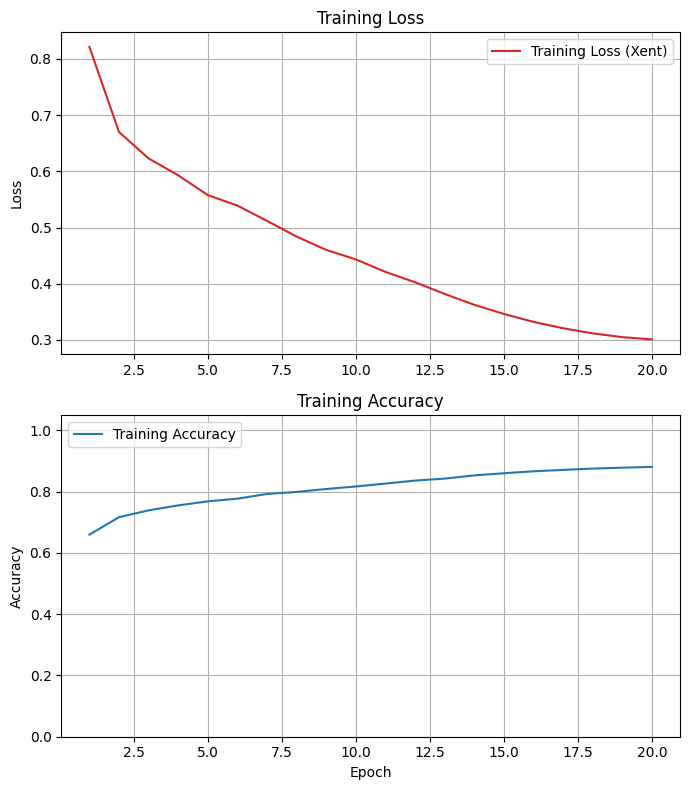

Final Training Loss:     0.3010
Final Training Accuracy: 0.8808
Test loss (init_lr=0.01): 0.4193
Test acc  (init_lr=0.01): 0.8422

Training with CosineDecay initial_learning_rate=0.005
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6551 - loss: 0.8317 - val_accuracy: 0.7306 - val_loss: 0.6619
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7233 - loss: 0.6499 - val_accuracy: 0.7512 - val_loss: 0.6052
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7483 - loss: 0.6020 - val_accuracy: 0.7694 - val_loss: 0.5632
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7644 - loss: 0.5623 - val_accuracy: 0.7806 - val_loss: 0.5504
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7775 - loss: 0.5328 - val_accuracy: 0.7868 - val_loss: 0.5271
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7900 - loss: 0.5089 - val_accuracy: 0.8019 - val_loss: 0.5049
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/

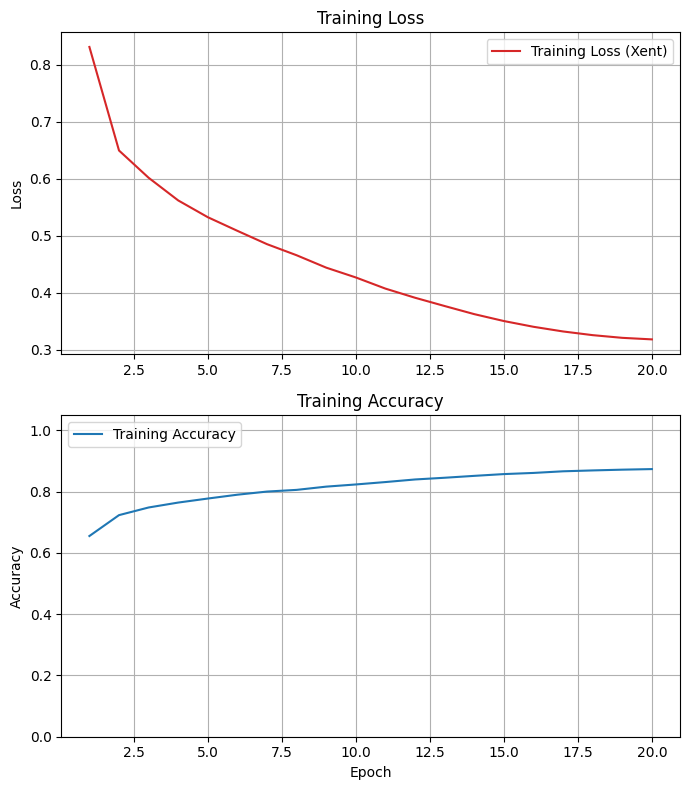

Final Training Loss:     0.3184
Final Training Accuracy: 0.8736
Test loss (init_lr=0.005): 0.4207
Test acc  (init_lr=0.005): 0.8318

Training with CosineDecay initial_learning_rate=0.001
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5962 - loss: 1.0323 - val_accuracy: 0.6958 - val_loss: 0.7603
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6926 - loss: 0.7404 - val_accuracy: 0.7270 - val_loss: 0.6755
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7201 - loss: 0.6738 - val_accuracy: 0.7452 - val_loss: 0.6307
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7364 - loss: 0.6325 - val_accuracy: 0.7553 - val_loss: 0.6009
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7517 - loss: 0.6021 - val_accuracy: 0.7618 - val_loss: 0.5788
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7619 - loss: 0.5788 - val_accuracy: 0.7733 - val_loss: 0.5611
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1m

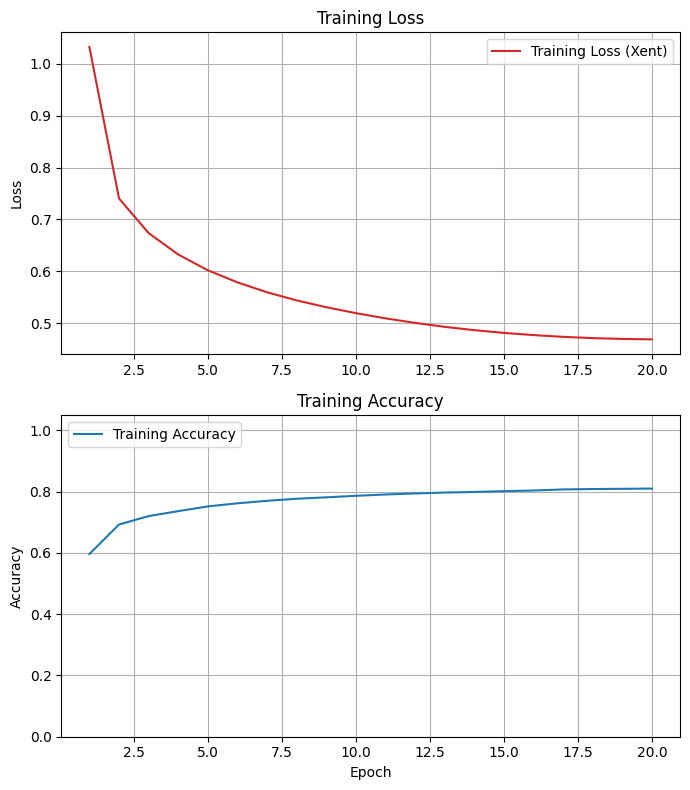

Final Training Loss:     0.4689
Final Training Accuracy: 0.8100
Test loss (init_lr=0.001): 0.4928
Test acc  (init_lr=0.001): 0.8001

Training with CosineDecay initial_learning_rate=0.0005
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5472 - loss: 1.1766 - val_accuracy: 0.6466 - val_loss: 0.8669
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6681 - loss: 0.8163 - val_accuracy: 0.6984 - val_loss: 0.7511
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6973 - loss: 0.7384 - val_accuracy: 0.7142 - val_loss: 0.6990
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7161 - loss: 0.6921 - val_accuracy: 0.7228 - val_loss: 0.6645
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7292 - loss: 0.6596 - val_accuracy: 0.7317 - val_loss: 0.6407
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7376 - loss: 0.6357 - val_accuracy: 0.7384 - val_loss: 0.6223
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1

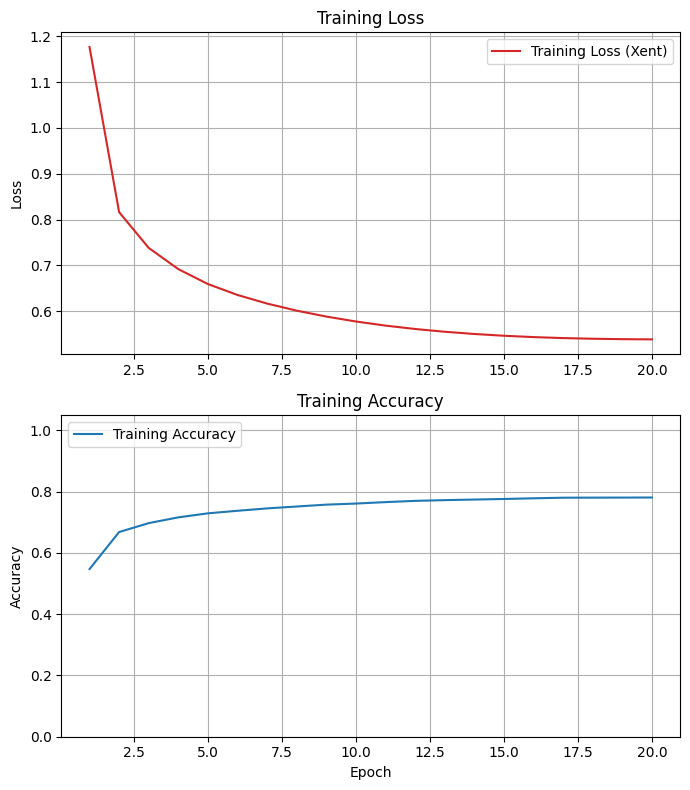

Final Training Loss:     0.5389
Final Training Accuracy: 0.7809
Test loss (init_lr=0.0005): 0.5543
Test acc  (init_lr=0.0005): 0.7678

Training with CosineDecay initial_learning_rate=0.0001
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2510 - loss: 1.8930 - val_accuracy: 0.4181 - val_loss: 1.6144
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4997 - loss: 1.4257 - val_accuracy: 0.5627 - val_loss: 1.2489
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5871 - loss: 1.1373 - val_accuracy: 0.6037 - val_loss: 1.0421
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6116 - loss: 0.9938 - val_accuracy: 0.6253 - val_loss: 0.9448
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6273 - loss: 0.9233 - val_accuracy: 0.6407 - val_loss: 0.8908
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6457 - loss: 0.8815 - val_accuracy: 0.6565 - val_loss: 0.8557
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s

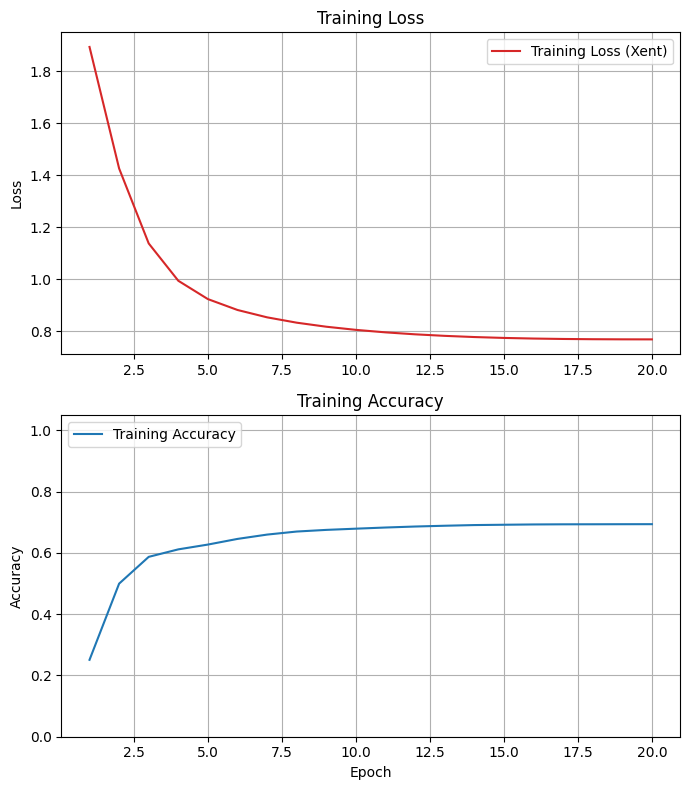

Final Training Loss:     0.7684
Final Training Accuracy: 0.6938
Test loss (init_lr=0.0001): 0.7576
Test acc  (init_lr=0.0001): 0.6940


In [ ]:
# Your code here
# Problem Four: CosineDecay scheduling experiments with Adam

initial_lrs = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
cos_histories = {}
cos_test_results = {}

n_classes = int(np.max(y_train)) + 1  # adjust if labels not 0..K-1

# A sensible default: decay over the whole training run
steps_per_epoch = int(np.ceil(len(X_train_std) / 32))
decay_steps = steps_per_epoch * 20   # 20 epochs total

for init_lr in initial_lrs:
    print("\n" + "="*60)
    print(f"Training with CosineDecay initial_learning_rate={init_lr}")

    lr_schedule = CosineDecay(
        initial_learning_rate=init_lr,
        decay_steps=decay_steps
        # alpha=0.0  # optional: final_lr = alpha * initial_lr
    )

    model_cos = Sequential([
        Input(shape=(X_train_std.shape[1],)),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(n_classes, activation="softmax")
    ])

    model_cos.compile(
        optimizer=Adam(learning_rate=lr_schedule),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    history_cos = model_cos.fit(
        X_train_std, y_train,
        validation_data=(X_test_std, y_test),
        epochs=20,
        batch_size=32,
        verbose=1
    )

    print(f"Curves for CosineDecay initial_learning_rate={init_lr}")
    plot_history(history_cos)

    loss_cos, acc_cos = model_cos.evaluate(X_test_std, y_test, verbose=0)
    print(f"Test loss (init_lr={init_lr}): {loss_cos:.4f}")
    print(f"Test acc  (init_lr={init_lr}): {acc_cos:.4f}")

    cos_histories[init_lr] = history_cos
    cos_test_results[init_lr] = (loss_cos, acc_cos)



In [ ]:
# Set a4a to the initial learning rate which produced the best accuracy

a4a = max(cos_histories, key=lambda lr: cos_histories[lr].history["accuracy"][-1])


In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a:.4f}') 

a4a = 0.0100


In [ ]:
# Set a4b to the best accuracy found

a4b = cos_histories[a4a].history["accuracy"][-1]


In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.8808


## Problem Five: Find the best model and run on the test set

In this final problem, you must consider all the experiments you've done and pick the
set of training hyperparameters which gives you the best accuracy after 20 epochs. Do not change the model architecture. 

Your choices are:

- Which batch size?
- Cosine Decay or constant learning rate?
    - If Cosine Decay, which initial learning rate?
    - If not, which constant learning rate?

* Display your results using `plot_history`
* Run your best model on the test set
* Answer the graded questions.


**OPTIONAL: change the model architecture (but use only dense layers) and try other learning rate schedulers (exponential, step, etc.)**

Best batch size (Problem 2): 4 train acc: 0.7719560265541077
Best constant LR (Problem 3): 0.001 train acc: 0.8168107867240906
Best cosine init LR (Problem 4): 0.01 train acc: 0.8807774782180786

OVERALL BEST: cosine {'batch_size': 32, 'schedule': 'cosine', 'init_lr': 0.01} train acc: 0.8807774782180786
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6557 - loss: 0.8193 - val_accuracy: 0.7150 - val_loss: 0.6670
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7170 - loss: 0.6668 - val_accuracy: 0.7402 - val_loss: 0.6195
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7411 - loss: 0.6185 - val_accuracy: 0.7582 - val_loss: 0.5853
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7578 - loss: 0.5845 - val_accuracy: 0.7764 - val_loss: 0.5482
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7688 - loss: 0.5581 - val_accuracy: 0.7735 - val_loss: 0.5429
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - a

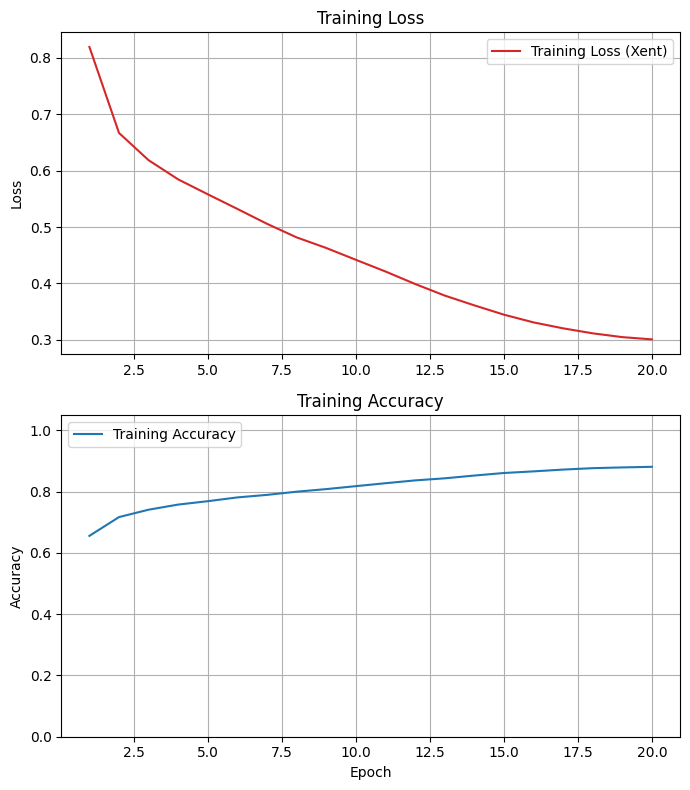

Final Training Loss:     0.3008
Final Training Accuracy: 0.8810
Best model test loss: 0.4416
Best model test accuracy: 0.8336


In [ ]:
# Your code here -- add as many cells as you need

# =========================
# Problem Five: Pick best hyperparameters across ALL experiments,
# retrain best model (same architecture), plot_history, evaluate on test.
# =========================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
import numpy as np

# --- helper: final training accuracy from a History object ---
def final_train_acc(hist):
    return hist.history["accuracy"][-1]

# --- 1) Find best from Problem Two (batch size runs; uses constant lr=1e-4 in your code) ---
best_bs = max(histories, key=lambda bs: final_train_acc(histories[bs]))
best_bs_acc = final_train_acc(histories[best_bs])

# --- 2) Find best from Problem Three (constant learning-rate runs; uses batch_size=32) ---
best_lr = max(lr_histories, key=lambda lr: final_train_acc(lr_histories[lr]))
best_lr_acc = final_train_acc(lr_histories[best_lr])

# --- 3) Find best from Problem Four (cosine-decay runs; uses batch_size=32) ---
best_cos_init = max(cos_histories, key=lambda lr: final_train_acc(cos_histories[lr]))
best_cos_acc = final_train_acc(cos_histories[best_cos_init])

print("Best batch size (Problem 2):", best_bs, "train acc:", best_bs_acc)
print("Best constant LR (Problem 3):", best_lr, "train acc:", best_lr_acc)
print("Best cosine init LR (Problem 4):", best_cos_init, "train acc:", best_cos_acc)

# --- 4) Choose the overall best option ---
candidates = [
    ("batch_size", {"batch_size": best_bs, "schedule": "constant", "lr": 1e-4}, best_bs_acc),
    ("const_lr",   {"batch_size": 32,     "schedule": "constant", "lr": best_lr}, best_lr_acc),
    ("cosine",     {"batch_size": 32,     "schedule": "cosine",   "init_lr": best_cos_init}, best_cos_acc),
]
best_name, best_cfg, best_acc = max(candidates, key=lambda t: t[2])

print("\nOVERALL BEST:", best_name, best_cfg, "train acc:", best_acc)

# --- 5) Retrain best model from scratch using that config ---
n_classes = int(np.max(y_train)) + 1  # adjust if labels not 0..K-1

# CosineDecay decay_steps over full training run (20 epochs)
steps_per_epoch = int(np.ceil(len(X_train_std) / best_cfg["batch_size"]))
decay_steps = steps_per_epoch * 20

if best_cfg.get("schedule") == "cosine":
    lr_schedule = CosineDecay(
        initial_learning_rate=best_cfg["init_lr"],
        decay_steps=decay_steps
    )
    optimizer = Adam(learning_rate=lr_schedule)
else:
    optimizer = Adam(learning_rate=best_cfg["lr"])

best_model = Sequential([
    Input(shape=(X_train_std.shape[1],)),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(n_classes, activation="softmax")
])

best_model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

best_history = best_model.fit(
    X_train_std, y_train,
    validation_data=(X_test_std, y_test),
    epochs=20,
    batch_size=best_cfg["batch_size"],
    verbose=1
)

plot_history(best_history)

# --- 6) Final evaluation on the test set ---
best_test_loss, best_test_acc = best_model.evaluate(X_test_std, y_test, verbose=0)
print(f"Best model test loss: {best_test_loss:.4f}")
print(f"Best model test accuracy: {best_test_acc:.4f}")

# If your notebook asks for graded variables, use expressions like these:
a5a = best_cfg["batch_size"]
# a5b = (best_cfg.get("init_lr") if best_cfg["schedule"]=="cosine" else best_cfg["lr"])
# a5c = best_history.history["accuracy"][-1]
# a5d = best_test_acc


In [ ]:
# Set a5a to the best training accuracy found by your best model

a5a = best_history.history["accuracy"][-1]

In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5a = {a5a:.4f}') 

a5a = 0.8810


In [ ]:
# Set a5b to the test accuracy found by your best model

a5b = best_test_acc


In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5b = {a5b:.4f}') 

a5b = 0.8336


## Reflection Questions (ungraded)

1. We trained on a perfectly balanced \~3.3% subset.
   If we *increase the subset size* (still balanced), how would you expect (a) training time, (b) the best **batch size**, and (c) the best **learning rate** to change? Why?

2. **Batch size trade-offs.**
   With epochs fixed, why do smaller batches often generalize better on tabular data than large batches? What would you change if you *must* use a large batch?

3. **More epochs, same LR.**
    If you doubled the number of epochs (no other changes), what do you think would happen to train loss/acc and test acc? 

4. **Epochs vs. LR.**
   It is natural to think that there is an inverse relationship between the number of epochs and learning rate: if you move more slowly, it will take you longer to reach your goal. Does this seem true given what we have seen in the experiments with learning rate?

# Appendix:  Forest Cover Type (Covertype) — Dataset Overview

This dataset pairs **cartographic features** of 30×30 m land plots with the **dominant tree cover type**. Your task is to predict the cover type from terrain and soil indicators—an archetypal **multi-class classification** problem on tabular data.

**At a glance**

* **Samples:** 581,012 original; we’ll use a **balanced subset** (e.g., 2747 per class) for faster, fairer training.
* **Features (54 total):**

  * **10 continuous:** elevation, aspect, slope, distances to hydrology/roads/fire points, and hillshade at 9 AM/noon/3 PM.
  * **44 binary:** **4 Wilderness\_Area** flags and **40 Soil\_Type** one-hot indicators.
* **Target (7 classes):** Spruce/Fir, Lodgepole Pine, Ponderosa Pine, Cottonwood/Willow, Aspen, Douglas-fir, Krummholz.

**Why it’s useful here**

* Realistic, **tabular** data with mixed feature types.
* Clear demonstration of **scaling** (continuous features) vs. **binary indicators**.
* Originally **imbalanced**, which motivates mindful evaluation (we avoid this by using a balanced subset).


Shape: (19229, 55)

Class distribution:
 Cover_Type
3    0.142857
2    0.142857
6    0.142857
5    0.142857
4    0.142857
1    0.142857
0    0.142857
Name: proportion, dtype: float64


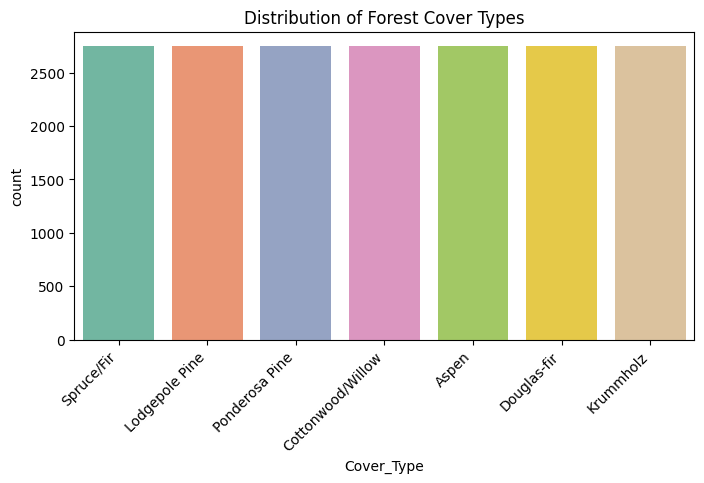

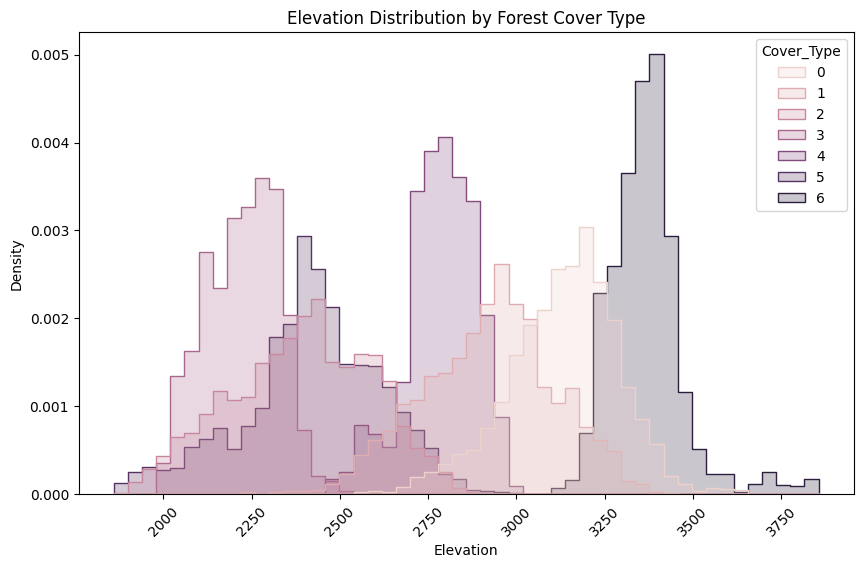

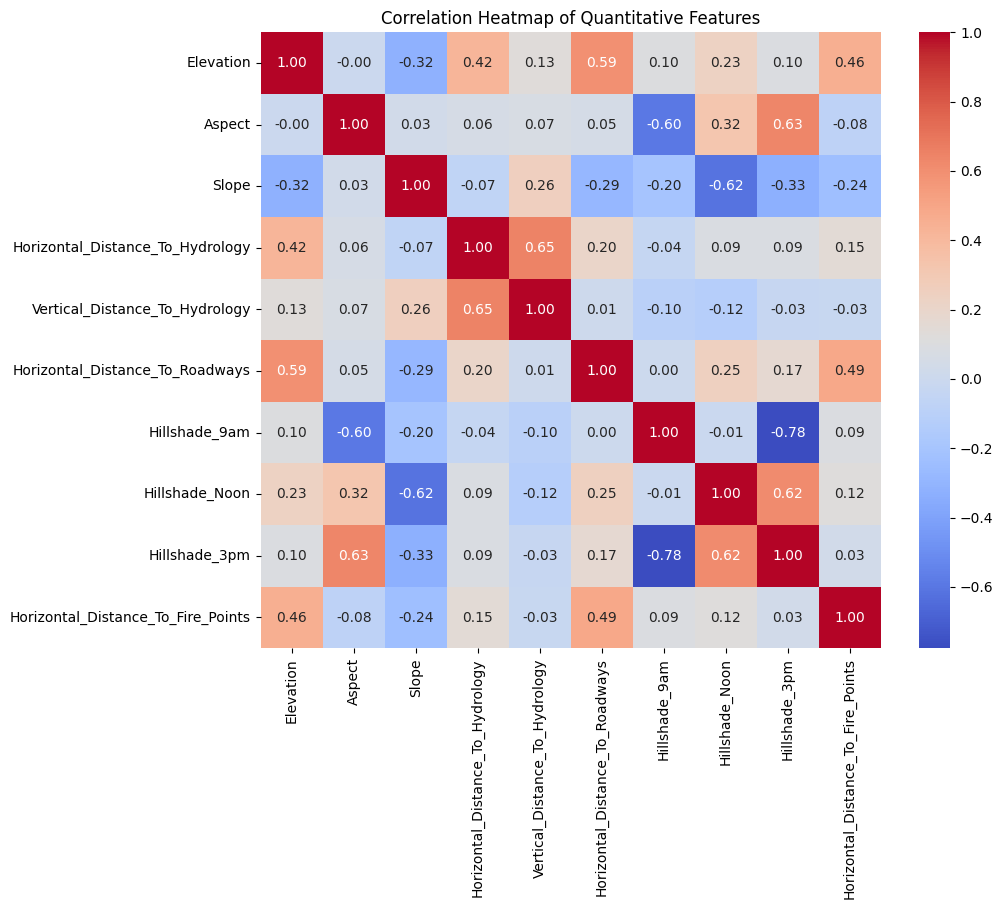

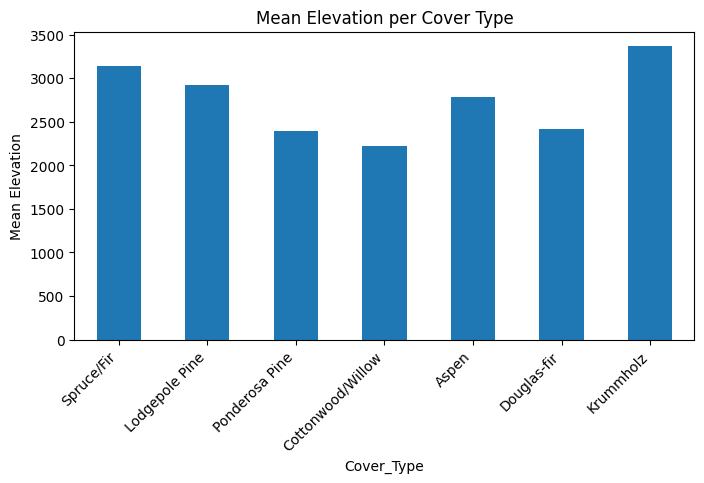

In [ ]:
# Attach feature + class names
quant_features = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]
wilderness_features = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_features = [f"Soil_Type{i}" for i in range(1, 41)]

feature_names = quant_features + wilderness_features + soil_features
class_names = [
    "Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine",
    "Cottonwood/Willow", "Aspen", "Douglas-fir", "Krummholz"
]

# Create dataframe from your subset
df = pd.DataFrame(X_sub, columns=feature_names)
df["Cover_Type"] = y_sub

# 1. Basic info
print("Shape:", df.shape)
print("\nClass distribution:\n", df["Cover_Type"].value_counts(normalize=True))

# 2. Class distribution plot
plt.figure(figsize=(8,4))
sns.countplot(x="Cover_Type", hue="Cover_Type", data=df, palette="Set2", legend=False)
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.title("Distribution of Forest Cover Types")
plt.show()

# 3. Elevation distribution by class
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="Elevation", hue="Cover_Type",
             bins=50, element="step", stat="density", common_norm=False)
plt.xticks(rotation=45)
plt.title("Elevation Distribution by Forest Cover Type")
plt.show()

# 4. Correlation heatmap (quantitative features only)
plt.figure(figsize=(10,8))
corr = df[quant_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Quantitative Features")
plt.show()

# 5. Mean elevation per cover type
df.groupby("Cover_Type")["Elevation"].mean().plot(kind="bar", figsize=(8,4))
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.ylabel("Mean Elevation")
plt.title("Mean Elevation per Cover Type")
plt.show()
